In [ ]:
https://dajiro.com/entry/2020/06/26/234720

In [ ]:
https://ymym3412.hatenablog.com/entry/2019/03/19/022240

In [ ]:
https://qiita.com/1ofoo/items/6787d9d1f35e6aba8b5b

In [ ]:
https://qiita.com/kinziro/items/69f996065b4a658c42e8

In [ ]:
https://github.com/vense/keras-grad-cam/blob/master/grad-cam.py

In [ ]:
http://urusulambda.com/2018/01/13/grad-cam%E3%81%AE%E8%AB%96%E6%96%87%E3%82%92%E6%B5%81%E3%81%97%E8%AA%AD%E3%82%80/

In [ ]:
https://www.ydc.co.jp/column/0002/20200217.html

In [ ]:
http://www.ie110704.net/2020/02/23/grad-cam%E3%80%81grad-cam%E3%80%81score-cam%E3%82%92%E5%AE%9F%E8%A3%85%E3%83%BB%E6%AF%94%E8%BC%83%E3%81%97%E3%81%A6%E3%81%BF%E3%81%9F/

In [ ]:
https://blog.brainpad.co.jp/entry/2017/07/10/163000

In [ ]:
https://keras.io/examples/vision/visualizing_what_convnets_learn/

In [ ]:
https://keras.io/examples/vision/grad_cam/

In [1]:
from keras.applications.vgg16 import (VGG16, preprocess_input, decode_predictions)
from keras.preprocessing import image
from keras.layers.core import Lambda
from keras.models import Sequential
from tensorflow.python.framework import ops
import keras.backend as K
import tensorflow as tf
import numpy as np
import keras
import sys
import cv2

Using TensorFlow backend.
C:\Users\ringa\anaconda3\envs\gan\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\ringa\anaconda3\envs\gan\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\ringa\anaconda3\envs\gan\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\ringa\anaconda3\envs\gan\lib\site-packages\t

In [2]:
def target_category_loss(x, category_index, nb_classes):
    return tf.multiply(x, K.one_hot([category_index], nb_classes))

def target_category_loss_output_shape(input_shape):
    return input_shape

def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)

In [3]:
def load_image(path):
    #img_path = sys.argv[1]
    img_path = path
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x


In [4]:
def register_gradient():
    if "GuidedBackProp" not in ops._gradient_registry._registry:
        @ops.RegisterGradient("GuidedBackProp")
        def _GuidedBackProp(op, grad):
            dtype = op.inputs[0].dtype
            return grad * tf.cast(grad > 0., dtype) * \
                tf.cast(op.inputs[0] > 0., dtype)

In [5]:
def compile_saliency_function(model, activation_layer='block5_conv3'):
    input_img = model.input
    layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])
    layer_output = layer_dict[activation_layer].output
    max_output = K.max(layer_output, axis=3)
    saliency = K.gradients(K.sum(max_output), input_img)[0]
    return K.function([input_img, K.learning_phase()], [saliency])


In [6]:
def modify_backprop(model, name):
    g = tf.get_default_graph()
    with g.gradient_override_map({'Relu': name}):

        # get layers that have an activation
        layer_dict = [layer for layer in model.layers[1:]
                      if hasattr(layer, 'activation')]

        # replace relu activation
        for layer in layer_dict:
            if layer.activation == keras.activations.relu:
                layer.activation = tf.nn.relu

        # re-instanciate a new model
        new_model = VGG16(weights='imagenet')
    return new_model

In [7]:
def deprocess_image(x):
    '''
    Same normalization as in:
    https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py
    '''
    if np.ndim(x) > 3:
        x = np.squeeze(x)
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_dim_ordering() == 'th':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [8]:
def grad_cam(input_model, image, category_index, layer_name):
    nb_classes = 1000
    target_layer = lambda x: target_category_loss(x, category_index, nb_classes)

    x = input_model.layers[-1].output
    x = Lambda(target_layer, output_shape=target_category_loss_output_shape)(x)
    model = keras.models.Model(input_model.layers[0].input, x)

    loss = K.sum(model.layers[-1].output)
    #conv_output = [l for l in model.layers[0].layers if l.name is layer_name][0].output
    conv_output = [l for l in model.layers if l.name is layer_name][0].output

    grads = normalize(K.gradients(loss, conv_output)[0])
    gradient_function = K.function([model.layers[0].input], [conv_output, grads])

    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis = (0, 1))
    cam = np.ones(output.shape[0 : 2], dtype = np.float32)

    for i, w in enumerate(weights):
        cam += w * output[:, :, i]

    cam = cv2.resize(cam, (224, 224))
    cam = np.maximum(cam, 0)
    heatmap = cam / np.max(cam)

    #Return to BGR [0..255] from the preprocessed image
    image = image[0, :]
    image -= np.min(image)
    image = np.minimum(image, 255)

    cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
    cam = np.float32(cam) + np.float32(image)
    cam = 255 * cam / np.max(cam)
    return np.uint8(cam), heatmap

In [11]:
#preprocessed_input = load_image(sys.argv[1])
preprocessed_input = load_image("C:\\Users\\ringa\\Desktop\\fol\\ringo.png")

model = VGG16(weights='imagenet')

predictions = model.predict(preprocessed_input)
top_1 = decode_predictions(predictions)[0][0]
print('Predicted class:')
print('%s (%s) with probability %.2f' % (top_1[1], top_1[0], top_1[2]))

predicted_class = np.argmax(predictions)
cam, heatmap = grad_cam(model, preprocessed_input, predicted_class, "block5_conv3")
cv2.imwrite("gradcam.jpg", cam)

register_gradient()
guided_model = modify_backprop(model, 'GuidedBackProp')
saliency_fn = compile_saliency_function(guided_model)
saliency = saliency_fn([preprocessed_input, 0])
gradcam = saliency[0] * heatmap[..., np.newaxis]
cv2.imwrite("guided_gradcam.jpg", deprocess_image(gradcam))

Instructions for updating:
Colocations handled automatically by placer.
40960/35363 [==================================] - 0s 0us/step
Predicted class:
crossword_puzzle (n06785654) with probability 0.64
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


True

In [ ]:
https://aidiary.hatenablog.com/entry/20170104/1483535144

In [19]:
predicted_class

918

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


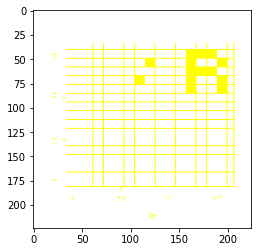

In [25]:
plt.imshow(preprocessed_input.reshape(224,224,3))

In [26]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions

In [28]:
preds = model.predict(preprocessed_input)
results = decode_predictions(preds, top=5)[0]
for result in results:
    print(result)

('n06785654', 'crossword_puzzle', 0.7761757)
('n03857828', 'oscilloscope', 0.12010648)
('n03733281', 'maze', 0.03831734)
('n04118776', 'rule', 0.023549763)
('n03598930', 'jigsaw_puzzle', 0.0068840147)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


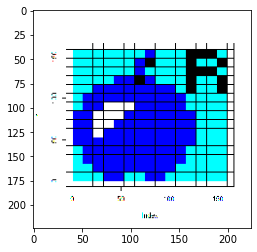

In [30]:
preprocessed_input = load_image("C:\\Users\\ringa\\Desktop\\fol\\ringo.png")
plt.imshow(preprocessed_input.reshape(224,224,3))

In [31]:
preds = model.predict(preprocessed_input)
results = decode_predictions(preds, top=5)[0]
for result in results:
    print(result)

('n06785654', 'crossword_puzzle', 0.6416888)
('n03857828', 'oscilloscope', 0.13189843)
('n03733281', 'maze', 0.08349703)
('n04118776', 'rule', 0.046675906)
('n03598930', 'jigsaw_puzzle', 0.018950865)


In [14]:
import matplotlib.pyplot as plt

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


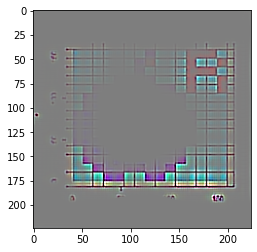

In [16]:
plt.imshow(gradcam.reshape(224,224,3))